In [111]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image ,ImageDraw
plt.ioff()
from scipy.signal import find_peaks

In [112]:
#Creating the image class to ease the operations and to maintain clean code
class ImageClass:
    
    def __init__(self,image):
         # convert to grayscale
        self.grayscale_image = image.convert('L')
        self.image_array = np.array(self.grayscale_image)
        self.image=image
        self.height,self.width=self.image_array.shape
        
    #calculate threshold for the image based on the pixel value of each pixel in the image
    def histogram_equalization(self, image_tile):
    # compute the histogram of the tile
        hist, bin_edges = np.histogram(image_tile.flatten(), bins=256, range=(0, 256))
    
    # compute the cumulative distribution function (CDF)
        cdf = hist.cumsum()
        cdf_normalized = cdf / cdf[-1]  # Normalize the CDF to [0, 1]

    # map the CDF values to the [0, 255] range
        cdf_mapped = np.floor(cdf_normalized * 255).astype(np.uint8)

    # use the CDF to map the original pixel values to the equalized ones
        equalized_image = cdf_mapped[image_tile]

        return equalized_image
    
    def thresh_hold(self):
        
        threshold = 128  # this value can be adjusted by looking at the histogram
        binary_image = np.where(self.image_array > threshold, 255, 0).astype(np.uint8)
        thresholded_image = Image.fromarray(binary_image)
        return thresholded_image
        
    #turn image to grayscale
    def to_gray_scale(self):
        
        return self.grayscale_image
        
    #turns image into halftoned image
    def halftone(self):
        
        dot_size=10
        halftone_image = Image.new('L', (self.width, self.height), 255)  # white background
        draw = ImageDraw.Draw(halftone_image)
        for y in range(0, self.height, dot_size):
                for x in range(0, self.width, dot_size):
                # extract the block
                    block = self.image_array[y:y+dot_size, x:x+dot_size]

            # calculate the average intensity of the block
                    average_intensity = np.mean(block)

            # map intensity to circle size
                    radius = int((255 - average_intensity) / 255 * (dot_size / 2))

            # draw the circle
                    center = (x + dot_size // 2, y + dot_size // 2)
                    draw.ellipse(
                        [center[0] - radius, center[1] - radius,
                        center[0] + radius, center[1] + radius],
                        fill=0 #black dots
                                            )
        return halftone_image
            

    #this function gets the histogram of the image
    def get_histogram(self):

        pixel_value=self.image_array.flatten()
        fig,ax=plt.subplots()
        ax.hist(pixel_value,bins=256,range=(0,256),color='gray',alpha=0.7)
        ax.set_title("GrayScale Histogram")
        ax.set_xlabel("Intensity")
        ax.set_ylabel("Frequency")
        return fig
    
    
    #the operation parameter controls if you want to use sobel or prewitt
    def simple(self, operation):
    # pad the image with zeros on all sides (1 pixel padding)
        padded_image = np.pad(self.image_array, ((1, 1), (1, 1)), mode="constant", constant_values=0)
    
    # Define the Sobel or Prewitt kernels
        if operation == 'sobel':
            kernel_x = np.array([[-1, 0, 1],
                             [-1, 0, 1],
                             [-1, 0, 1]], dtype=np.float32)
            kernel_y = np.array([[-1, -1, -1],
                             [0,  0,  0],
                             [1,  1,  1]], dtype=np.float32)
        elif operation == "prewitt":
            kernel_x = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]], dtype=np.float32)
            kernel_y = np.array([[-1, -2, -1],
                             [0,  0,  0],
                             [1,  2,  1]], dtype=np.float32)
    
    # apply the kernels to get the gradients in x and y directions using array slicing
        grad_x = (
        kernel_x[0, 0] * padded_image[:-2, :-2] +
        kernel_x[0, 1] * padded_image[:-2, 1:-1] +
        kernel_x[0, 2] * padded_image[:-2, 2:] +
        kernel_x[1, 0] * padded_image[1:-1, :-2] +
        kernel_x[1, 1] * padded_image[1:-1, 1:-1] +
        kernel_x[1, 2] * padded_image[1:-1, 2:] +
        kernel_x[2, 0] * padded_image[2:, :-2] +
        kernel_x[2, 1] * padded_image[2:, 1:-1] +
        kernel_x[2, 2] * padded_image[2:, 2:]
    )

        grad_y = (
        kernel_y[0, 0] * padded_image[:-2, :-2] +
        kernel_y[0, 1] * padded_image[:-2, 1:-1] +
        kernel_y[0, 2] * padded_image[:-2, 2:] +
        kernel_y[1, 0] * padded_image[1:-1, :-2] +
        kernel_y[1, 1] * padded_image[1:-1, 1:-1] +
        kernel_y[1, 2] * padded_image[1:-1, 2:] +
        kernel_y[2, 0] * padded_image[2:, :-2] +
        kernel_y[2, 1] * padded_image[2:, 1:-1] +
        kernel_y[2, 2] * padded_image[2:, 2:]
    )
    
    # compute the gradient magnitude
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # normalize the magnitude to the range 0-255
        grad_magnitude = (grad_magnitude / grad_magnitude.max()) * 255

    # Convert to uint8 for image representation
        kernelized_image = Image.fromarray(grad_magnitude.astype(np.uint8))
    
        return kernelized_image

        
    #the operation parameter controls the various techqinues of advanced edge detection
    def advanced(self,operation):
        #define parameters
        window_size=3
        offset = window_size // 2
        hd_image = np.zeros_like(self.image_array)
        if operation=='homo':
            for y in range(offset, self.height - offset):
                for x in range(offset, self.width - offset):
            # Extract the local neighborhood (window) around the current pixel
                    window = self.image_array[y - offset:y + offset + 1, x - offset:x + offset + 1]
                    
            #local variance (contrast)
                    variance = np.var(window)
                    contrast = np.sqrt(variance)
                    
            #inverse of contrast
                    homogeneity = 1 / (contrast + 1e-5)  # Add small epsilon to avoid division by zero
                    
            #the homogeneity value to the output
                    hd_image[y, x] = homogeneity * 255  # Scale to 0-255 for display
                    
    # normalize
            hd_image = np.uint8(hd_image / np.max(hd_image) * 255)
            hd_image=Image.fromarray(hd_image)
        elif operation=="diffrence":
            for y in range(offset, self.height - offset):
                for x in range(offset, self.width - offset):
            # extract the local neighborhood (window) around the current pixel
                    window = self.image_array[y - offset:y + offset + 1, x - offset:x + offset + 1]
            
            # compute the maximum and minimum intensities in the window
                    max_intensity = np.max(window)
                    min_intensity = np.min(window)
            
            # calculate the intensity difference
                    difference = max_intensity - min_intensity
            
            # assign the difference value to the output image
                    hd_image[y, x] = difference
    # normalize the output to ensure the values are within 0-255
            hd_image = np.uint8(hd_image / np.max(hd_image) * 255)
            hd_image=Image.fromarray(hd_image)
        elif operation=="var":
            for y in range(offset, self.height - offset):
                for x in range(offset, self.width - offset):
            # extract the 3x3 local neighborhood (window) around the current pixel
                    window = self.image_array[y - offset:y + offset + 1, x - offset:x + offset + 1]
            
            # get the variance for each window
                    variance = np.var(window)
            
            # replace the center pixel with the calculated variance
                    hd_image[y, x] = variance
    # Convert to uint8 for display (scale the variance to the 0-255 range)
            hd_image = np.clip(hd_image, 0, 255).astype(np.uint8)
            hd_image=Image.fromarray(hd_image)
        elif operation=="range":
            for y in range(offset, self.height - offset):
                for x in range(offset, self.width - offset):
            # Extract the 3x3 local neighborhood (window) around the current pixel
                    window = self.image_array[y - offset:y + offset + 1, x - offset:x + offset + 1]
            
            # Calculate the range of the window (max - min)
                    pixel_range = np.max(window) - np.min(window)
            
            # Replace the center pixel with the calculated range
                    hd_image[y, x] = pixel_range
    # Convert to uint8 for display (scale the range to the 0-255 range)
        hd_image = np.clip(hd_image, 0, 255).astype(np.uint8)
        hd_image=Image.fromarray(hd_image)
        return hd_image
    #the level parameter controls the level of the filer used high low or median
    def filtering(self, level):
        window_size = 3
        if level == "high":
            kernel = np.array([[0, 1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]], dtype=np.float32)
        elif level == "median":
            # the median filter does not require a kernel; it operates by getting the median of the surrounding pixels.
            padded_image = np.pad(self.image_array, ((window_size//2, window_size//2), (window_size//2, window_size//2)), mode='constant')
            filtered_image = np.zeros_like(self.image_array)
            # Iterate over the entire image, excluding borders due to padding
            for i in range(window_size//2, padded_image.shape[0] - window_size//2):
                for j in range(window_size//2, padded_image.shape[1] - window_size//2):
                    window = padded_image[i - window_size//2:i + window_size//2 + 1, j - window_size//2:j + window_size//2 + 1]
                    filtered_image[i - window_size//2, j - window_size//2] = np.median(window)
            # convert the filtered array back to an Image object if needed
            filtered_image = Image.fromarray(filtered_image)
        elif level == "low":
            kernel = np.array([[0, 1, 0],
                               [1, 2, 1],
                               [0, 1, 0]], dtype=np.float32) / 6
        
        # apply kernel (convolution) for high or low filter
        if level != "median":
            image_padded = np.pad(self.image_array, ((1, 1), (1, 1)), mode='constant', constant_values=0)
            filtered_image = np.zeros_like(self.image_array, dtype=np.float32)
            for i in range(1, image_padded.shape[0] - 1):
                for j in range(1, image_padded.shape[1] - 1):
                    region = image_padded[i-1:i+2, j-1:j+2]
                    filtered_image[i-1, j-1] = np.sum(region * kernel, axis=(0, 1))
        
            # convert back to image
            filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)  # Ensure valid image values
            filtered_image = Image.fromarray(filtered_image)

        return filtered_image

    #this function does one of 3 thing it creates a copy of the image and either add it to the image itself or subtract image from itself or invert the image
    def operations(self,operation):
        image_copy=self.image_array.copy()
        if operation=="add":
            added_array=np.clip(self.image_array+image_copy,0,255)
            added_image=Image.fromarray(added_array)
            return added_image
        elif operation=="subtract":
            sub_array=np.clip(self.image_array-image_copy,0,255)
            sub_image=Image.fromarray(sub_array)
            return sub_image
        elif operation=="invert":
            inverted_array=255-self.image_array
            inverted_image=Image.fromarray(inverted_array)
            return inverted_image
    #this function either performs the manual, adaptive,histogram valley or histogram technique to detect edges
    def histogram_segmentation(self,operation):
        #normalizing image to 0 to 1 [0,1]
        normailzed_image=self.image_array/255.0
        
        if operation=="manual":
            #here i am going to set the threshold manually by defing an upper and lower bound they are put by looking at the histogram of the image
            high_threshold=0.4
            low_threshold=0.15
                
        elif operation=="valley":
            # Compute histogram and bin edges
            hist, bin_edges = np.histogram(normailzed_image, bins=256, range=(0, 1))
            peaks,_=find_peaks(-hist,prominence=10)
            valleys=bin_edges[peaks]
            low_threshold,high_threshold=valleys[:2]
            
        elif operation=="peak":
            hist, bin_edges = np.histogram(normailzed_image, bins=256, range=(0, 1))
            peaks,_=find_peaks(hist,prominence=10)
            valleys=bin_edges[peaks]
            low_threshold,high_threshold=valleys[:2]
            
        elif operation=="adapt":
            tile_size=(8,8)#this is set manually and can be changed depending on the circumstances
            tile_height, tile_width = tile_size
            tiles_y = self.height // tile_height
            tiles_x = self.width // tile_width
            segmented_image=np.zeros_like(self.image_array)
            
            for i in range(tiles_y):
                
                for j in range(tiles_x):
                    y_start=i*tile_height
                    y_end=(i+1)*tile_height
                    x_start=j*tile_width
                    x_end=(j+1)*tile_width
                    tile = self.image_array[y_start:y_end, x_start:x_end]
                    tile_eq = self.histogram_equalization(tile)
                    segmented_image[y_start:y_end, x_start:x_end] = tile_eq
            segmented_image=Image.fromarray(segmented_image)
            
        fig,ax=plt.subplots(figsize=(10,10))
        ax.hist(normailzed_image.flat,bins=80,range=(0,1),color="gray")
        ax.set_title("Histogram of a gray scale image")
        ax.set_xlabel("Intensity")
        ax.set_ylabel("Frequency")
        
        if operation !="adapt":
            segmented_image=np.zeros_like(self.image_array) #initalize blank image
        #we will define 3 regions the high threshold and low threshlod and what is in between
            region_1=(normailzed_image<=low_threshold)#dark regions
            region_2=(normailzed_image>high_threshold)#bright region
            region_3 = (normailzed_image > low_threshold) & (self.image_array <= high_threshold)#grayish region
        #assigning a value to each one coressponding to the correct region
            segmented_image[region_1]=0
            segmented_image[region_2]=255
            segmented_image[region_3]=128
            segmented_image=Image.fromarray(segmented_image)#scaling back to the 0 to 255 [0,255] range
        return segmented_image
    
    def kirsch(self):
        #kirsch compass masks
        kirsch_masks = {
        "N": np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),
        "NE": np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]),
        "E": np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]),
        "SE": np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]),
        "S": np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]),
        "SW": np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]),
        "W": np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]),
        "NW": np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]),
}
        padded_image = np.pad(self.image_array, pad_width=1, mode='constant', constant_values=0) #padding the image
        edge_intensity = np.zeros((self.height, self.width), dtype=np.float32)
        edge_direction = np.empty((self.height, self.width), dtype=object)
        for i in range(1, self.height + 1):  # Loop over rows
            for j in range(1, self.width + 1):  # Loop over columns
                responses = {}
                for direction, mask in kirsch_masks.items():
                    region = padded_image[i-1:i+2, j-1:j+2]  # Extract the 3x3 region
                    response = np.sum(region * mask)  # Compute convolution
                    responses[direction] = response
        
        # find the maximum response and corresponding direction
                max_direction = max(responses, key=responses.get)
                max_response = responses[max_direction]
        
                edge_intensity[i-1, j-1] = max_response
                edge_direction[i-1, j-1] = max_direction

#normalize edge intensity to [0, 255]
        edge_intensity = np.clip((edge_intensity / edge_intensity.max()) * 255, 0, 255).astype(np.uint8)
        edge_intensity=Image.fromarray(edge_intensity)
        return edge_direction,edge_intensity

In [113]:
I1=ImageClass(Image.open('test1.jpg'))
image=I1.advanced(operation="range")

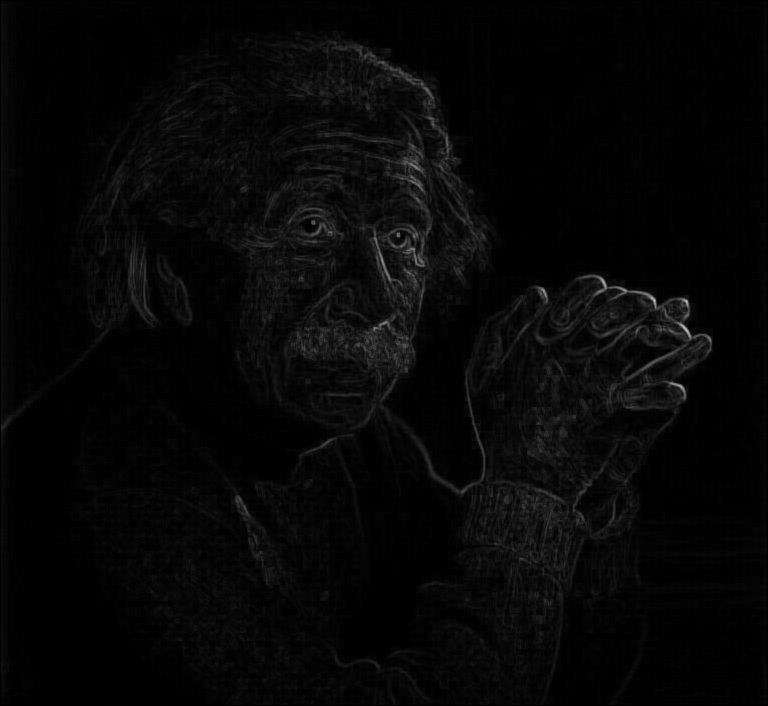

In [114]:
image